# **FedProx in Fluke**

In [1]:
import os
import sys
from copy import deepcopy
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

# New federated algorithm with `fluke`

This tutorial will guide you through the steps required to implement a new federated learning algorithm that can be tested with ``fluke``.

```{attention}
This tutorial does not go into the details of the implementation, but it provides a quick overview of the steps required to implement a new federated learning algorithm.
For a more in-depth guide on how to implement your own federated learning algorithm, please refer to [this section](../../add_algorithm.md).
```

Try this notebook: [![Open in Colab](https://img.shields.io/badge/Open_in_Colab-blue?style=flat-square&logo=google-colab&logoColor=yellow&labelColor=gray)
](https://colab.research.google.com/github/CasellaJr/Fluke-tutorial-ECAI25/blob/main/1_fluke_custom_alg.ipynb)

## Install `fluke` (if not already done)

In [2]:
!pip install fluke-fl

## Implementing the client-side logic

To keep it simple, we use a very easy and not particulary smart :) example of a new FL algorithm.
Let's say we want define a new federated algorithm with these two characteristics:
- At each round, the server aggregates the parameters via the **median** (conversely to the typical averaging strategy)
- A client will follow the **FedProx** algorithm (i.e., adding a penalty loss)

Let's start with the client. The only thing the client does differently from the standard FedAvg client is to add a penalty term to the loss function. The rest of the logic is the same.

Most of the server's behaviour is the same as in `FedAvg` that is already implemented in `fluke.server.Server`.

## Implementing the client-side logic

Let's implement the client-side logic. Also in this case we can start from the `FedAvg` client that is already implemented in `fluke.client.Client` and modify it to fit our needs.

In [ ]:
from typing import Collection, Sequence
from torch.nn import Module
from fluke.client import Client
from fluke.server import Server
import numpy as np

import torch
from fluke.data import FastDataLoader
from fluke.config import OptimizerConfigurator
from fluke.utils import clear_cuda_cache

class FedProxClient(Client):
    def __init__(
        self,
        index: int,
        train_set: FastDataLoader,
        test_set: FastDataLoader,
        optimizer_cfg: OptimizerConfigurator,
        loss_fn: torch.nn.Module,
        local_epochs: int,
        mu: float,
        fine_tuning_epochs: int = 0,
        clipping: float = 0,
        **kwargs,
    ):
        super().__init__(
            index=index,
            train_set=train_set,
            test_set=test_set,
            optimizer_cfg=optimizer_cfg,
            loss_fn=loss_fn,
            local_epochs=local_epochs,
            fine_tuning_epochs=fine_tuning_epochs,
            clipping=clipping,
            **kwargs,
        )
        self.hyper_params.update(mu=mu)

    def _proximal_loss(self, local_model: torch.nn.Module, global_model: torch.nn.Module) -> float:
        proximal_term = 0.0
        for w, w_t in zip(local_model.parameters(), global_model.parameters()):
            if w_t.requires_grad:
                proximal_term += (w - w_t).norm(2) ** 2
        return proximal_term

      # we override the fit method to implement our training "strategy"
    def fit(self, override_local_epochs: int = 0) -> float:
        epochs: int = (
            override_local_epochs if override_local_epochs > 0 else self.hyper_params.local_epochs
        )
        W = deepcopy(self.model).to(self.device)
        self.model.to(self.device)
        self.model.train()

        if self.optimizer is None:
            self.optimizer, self.scheduler = self._optimizer_cfg(self.model)

        running_loss = 0.0
        for _ in range(epochs):
            loss = None
            for _, (X, y) in enumerate(self.train_set):
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                y_hat = self.model(X)
                loss = self.hyper_params.loss_fn(y_hat, y) + (
                    self.hyper_params.mu / 2
                ) * self._proximal_loss(self.model, W)
                loss.backward()
                self._clip_grads(self.model)
                self.optimizer.step()
                running_loss += loss.item()
            self.scheduler.step()

        running_loss /= epochs * len(self.train_set)
        self.model.cpu()
        W.cpu()
        clear_cuda_cache()
        return running_loss

## Implementing the new federated algorithm

Now, we only need to put everything together in a new class that inherits from `fluke.algorithms.CentralizedFL` specifying the server and client classes we just implemented.

In [4]:
from fluke.algorithms import CentralizedFL

class FedProx(CentralizedFL):

    def get_client_class(self) -> type[Client]:
        return FedProxClient

Everything is ready! Now we can test our new federated algorithm with `fluke`!

## Ready to test the new federated algorithm

The rest of the code is the same as in the [First steps with `fluke` API](fluke_quick_api.ipynb) tutorial.

In [ ]:
from fluke.data import DataSplitter
from fluke.data.datasets import Datasets
from fluke import DDict
from fluke.utils.log import Log
from fluke.evaluation import ClassificationEval
from fluke import FlukeENV
from fluke.utils import plot_distribution

env = FlukeENV()
env.set_seed(42) # we set a seed for reproducibility
env.set_device("cpu") # we use the CUDA for this example

dataset = Datasets.get("mnist", path="./data")

# we set the evaluator to be used by both the server and the clients
env.set_evaluator(ClassificationEval(eval_every=1, n_classes=dataset.num_classes))

splitter = DataSplitter(dataset=dataset,
                        distribution="iid")

client_hp = DDict(
    batch_size=10,
    local_epochs=5,
    loss="CrossEntropyLoss",
    mu=0.3,
    optimizer=DDict(
      lr=0.01,
      momentum=0.9,
      weight_decay=0.0001),
    scheduler=DDict(
      gamma=1,
      step_size=1)
)

# we put together the hyperparameters for the algorithm
hyperparams = DDict(client=client_hp,
                    server=DDict(weighted=True),
                    model="MNIST_2NN")

[UnsupportedFieldAttributeWarning] /Users/samuelefonio/Desktop/ECAI25/Tutorial/ecai_venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249
The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
[UnsupportedFieldAttributeWarning] /Users/samuelefonio/Desktop/ECAI25/Tutorial/ecai_venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249
The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This 

Here is where the new federated algorithm comes into play.

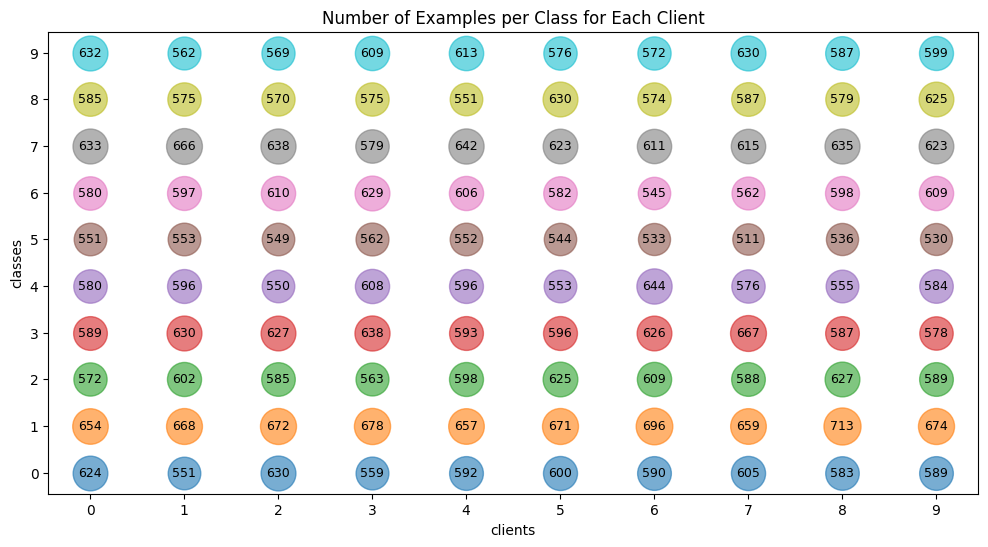

In [6]:
algorithm = FedProx(n_clients=10, # 10 clients in the federation
                    data_splitter=splitter,
                    hyper_params=hyperparams)

plot_distribution(algorithm.clients, plot_type="ball") #mat, ball, bar

logger = Log()
algorithm.set_callbacks(logger)

We only just need to run it!

In [7]:
logger.init()

In [8]:
algorithm.run(n_rounds=2, eligible_perc=0.5)

Output()

╭──────────────────────────────────────────── Round: 1 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9551,                                                                      │
│         'macro_precision': 0.95514,                                                              │
│         'macro_recall': 0.95447,                                                                 │
│         'macro_f1': 0.95451,                                                                     │
│         'micro_precision': 0.9551,                                                               │
│         'micro_recall': 0.9551,                                                                  │
│         'micro_f1': 0.9551,                                                                      │
│         'round': 1                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 636.1 MB [5.36 %]

╭──────────────────────────────────────────── Round: 2 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9712,                                                                      │
│         'macro_precision': 0.97103,                                                              │
│         'macro_recall': 0.97091,                                                                 │
│         'macro_f1': 0.97092,                                                                     │
│         'micro_precision': 0.9712,                                                               │
│         'micro_recall': 0.9712,                                                                  │
│         'micro_f1': 0.9712,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 599.9 MB [5.42 %]

Output()

╭────────────────────────────────────── Overall Performance ───────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9712,                                                                      │
│         'macro_precision': 0.97103,                                                              │
│         'macro_recall': 0.97091,                                                                 │
│         'macro_f1': 0.97092,                                                                     │
│         'micro_precision': 0.9712,                                                               │
│         'micro_recall': 0.9712,                                                                  │
│         'micro_f1': 0.9712,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_costs': 4808970                                                                        │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

## Comparison with FedAvg in a non-IID scenario

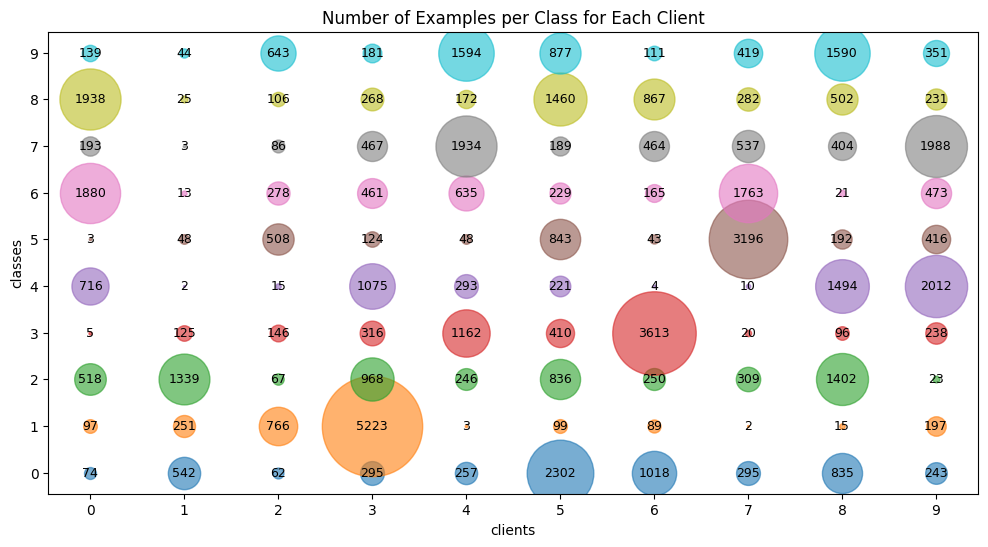

In [9]:
from fluke.algorithms.fedavg import FedAVG

splitter = DataSplitter(dataset=dataset,
                        distribution="dir", dist_args={"beta":0.5})

fedavg_non_iid = FedAVG(n_clients=10, # 10 clients in the federation
                    data_splitter=splitter,
                    hyper_params=hyperparams)

plot_distribution(fedavg_non_iid.clients, plot_type="ball") #mat, ball, bar



In [10]:
logger = Log()
fedavg_non_iid.set_callbacks(logger)

logger.init()

fedavg_non_iid.run(n_rounds=2, eligible_perc=0.5)

╭──────────────────────────────────────────── Round: 1 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9177,                                                                      │
│         'macro_precision': 0.92031,                                                              │
│         'macro_recall': 0.9179,                                                                  │
│         'macro_f1': 0.91651,                                                                     │
│         'micro_precision': 0.9177,                                                               │
│         'micro_recall': 0.9177,                                                                  │
│         'micro_f1': 0.9177,                                                                      │
│         'round': 1                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 234.6 MB [6.43 %]

╭──────────────────────────────────────────── Round: 2 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9519,                                                                      │
│         'macro_precision': 0.95322,                                                              │
│         'macro_recall': 0.95081,                                                                 │
│         'macro_f1': 0.95116,                                                                     │
│         'micro_precision': 0.9519,                                                               │
│         'micro_recall': 0.9519,                                                                  │
│         'micro_f1': 0.9519,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 244.0 MB [6.66 %]

╭────────────────────────────────────── Overall Performance ───────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9519,                                                                      │
│         'macro_precision': 0.95322,                                                              │
│         'macro_recall': 0.95081,                                                                 │
│         'macro_f1': 0.95116,                                                                     │
│         'micro_precision': 0.9519,                                                               │
│         'micro_recall': 0.9519,                                                                  │
│         'micro_f1': 0.9519,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_costs': 4987080                                                                        │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
fedprox_non_iid = FedProx(n_clients=10, # 10 clients in the federation
                    data_splitter=splitter,
                    hyper_params={**hyperparams, "mu": 0.1})

logger = Log()
fedprox_non_iid.set_callbacks(logger)

logger.init()

fedprox_non_iid.run(n_rounds=2, eligible_perc=0.5)

╭──────────────────────────────────────────── Round: 1 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.7728,                                                                      │
│         'macro_precision': 0.84139,                                                              │
│         'macro_recall': 0.78216,                                                                 │
│         'macro_f1': 0.74835,                                                                     │
│         'micro_precision': 0.7728,                                                               │
│         'micro_recall': 0.7728,                                                                  │
│         'micro_f1': 0.7728,                                                                      │
│         'round': 1                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 291.7 MB [7.83 %]

╭──────────────────────────────────────────── Round: 2 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9592,                                                                      │
│         'macro_precision': 0.9599,                                                               │
│         'macro_recall': 0.95833,                                                                 │
│         'macro_f1': 0.9587,                                                                      │
│         'micro_precision': 0.9592,                                                               │
│         'micro_recall': 0.9592,                                                                  │
│         'micro_f1': 0.9592,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 292.2 MB [7.84 %]

╭────────────────────────────────────── Overall Performance ───────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9592,                                                                      │
│         'macro_precision': 0.9599,                                                               │
│         'macro_recall': 0.95833,                                                                 │
│         'macro_f1': 0.9587,                                                                      │
│         'micro_precision': 0.9592,                                                               │
│         'micro_recall': 0.9592,                                                                  │
│         'micro_f1': 0.9592,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_costs': 4987080                                                                        │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

## Implementing the server-side logic
Let's continue with the server. Given the characteristics of the algorithm, the only thing the server does differently from the standard FedAvg server is to use the median to aggregate the parameters, rather than the mean. The primary motivation for using the median is robustness. Averaging is highly susceptible to corrupt or malicious updates, while the median is remarkably resilient. For the same parameter (the first row, first column), you take the values from all 100 devices, line them up in order from smallest to largest, and pick the middle value.
The rest of the logic is the same.

In [12]:
import torch
import torch.nn as nn
from copy import deepcopy
from typing import Iterable, Sequence

class FedProxServer(Server):
    def aggregate(
        self,
        eligible: Sequence[Client],
        client_models: Iterable[torch.nn.Module]
    ) -> None:

        # Convert models to list for multiple iterations
        models_list = list(client_models)
        # Get model parameters
        model_params = dict(self.model.named_parameters())
        
        for key in model_params.keys():
            tensors = []
            for m in models_list:
                tensors.append(dict(m.named_parameters())[key].data)
                
            # Stack all parameter values and compute median along the client dimension
            stacked = torch.stack(tensors, dim=0)
            median_val = torch.median(stacked, dim=0).values
            model_params[key].data.copy_(median_val)

        self.model.load_state_dict(model_params)
        
        return deepcopy(self.model)

In [13]:
class FedProx(CentralizedFL):

    def get_client_class(self) -> type[Client]:
        return FedProxClient

    def get_server_class(self) -> type[Server]:
        return FedProxServer

In [14]:
median_fedprox_non_iid = FedProx(n_clients=10, # 10 clients in the federation
                    data_splitter=splitter,
                    hyper_params={**hyperparams, "mu": 0.1})

logger = Log()
median_fedprox_non_iid.set_callbacks(logger)

logger.init()

median_fedprox_non_iid.run(n_rounds=2, eligible_perc=0.5)

╭──────────────────────────────────────────── Round: 1 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.7299,                                                                      │
│         'macro_precision': 0.82235,                                                              │
│         'macro_recall': 0.72329,                                                                 │
│         'macro_f1': 0.67574,                                                                     │
│         'micro_precision': 0.7299,                                                               │
│         'micro_recall': 0.7299,                                                                  │
│         'micro_f1': 0.7299,                                                                      │
│         'round': 1                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 324.5 MB [8.63 %]

╭──────────────────────────────────────────── Round: 2 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9402,                                                                      │
│         'macro_precision': 0.94129,                                                              │
│         'macro_recall': 0.93918,                                                                 │
│         'macro_f1': 0.93914,                                                                     │
│         'micro_precision': 0.9402,                                                               │
│         'micro_recall': 0.9402,                                                                  │
│         'micro_f1': 0.9402,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_cost': 1781100                                                                         │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 339.1 MB [8.99 %]

╭────────────────────────────────────── Overall Performance ───────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9402,                                                                      │
│         'macro_precision': 0.94129,                                                              │
│         'macro_recall': 0.93918,                                                                 │
│         'macro_f1': 0.93914,                                                                     │
│         'micro_precision': 0.9402,                                                               │
│         'micro_recall': 0.9402,                                                                  │
│         'micro_f1': 0.9402,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_costs': 4987080                                                                        │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

## Using a custom model in fluke
For the purpose of this tutorial, we will define a very simple neural network for the MNIST dataset. The network will have two hidden layers with ReLU activation function.

In [15]:
from torch.functional import F

class MyMLP(torch.nn.Module):

    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 100)
        self.fc2 = torch.nn.Linear(100, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
hyperparams = DDict(client=client_hp,
                    server=DDict(weighted=True),
                    model=MyMLP())

median_fedprox_non_iid = FedProx(n_clients=10, # 10 clients in the federation
                    data_splitter=splitter,
                    hyper_params={**hyperparams, "mu": 0.1})

logger = Log()
median_fedprox_non_iid.set_callbacks(logger)

logger.init()

median_fedprox_non_iid.run(n_rounds=2, eligible_perc=0.5)

╭──────────────────────────────────────────── Round: 1 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.8811,                                                                      │
│         'macro_precision': 0.88945,                                                              │
│         'macro_recall': 0.88104,                                                                 │
│         'macro_f1': 0.87891,                                                                     │
│         'micro_precision': 0.8811,                                                               │
│         'micro_recall': 0.8811,                                                                  │
│         'micro_f1': 0.8811,                                                                      │
│         'round': 1                                                                               │
│     },                                                                                           │
│     'comm_cost': 856140                                                                          │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 335.9 MB [8.91 %]

╭──────────────────────────────────────────── Round: 2 ────────────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9487,                                                                      │
│         'macro_precision': 0.94863,                                                              │
│         'macro_recall': 0.94816,                                                                 │
│         'macro_f1': 0.94799,                                                                     │
│         'micro_precision': 0.9487,                                                               │
│         'micro_recall': 0.9487,                                                                  │
│         'micro_f1': 0.9487,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_cost': 856140                                                                          │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Memory usage: 336.3 MB [8.92 %]

╭────────────────────────────────────── Overall Performance ───────────────────────────────────────╮
│ {                                                                                                │
│     'global': {                                                                                  │
│         'accuracy': 0.9487,                                                                      │
│         'macro_precision': 0.94863,                                                              │
│         'macro_recall': 0.94816,                                                                 │
│         'macro_f1': 0.94799,                                                                     │
│         'micro_precision': 0.9487,                                                               │
│         'micro_recall': 0.9487,                                                                  │
│         'micro_f1': 0.9487,                                                                      │
│         'round': 2                                                                               │
│     },                                                                                           │
│     'comm_costs': 2397192                                                                        │
│ }                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯